# Prediction
After the exploratory data analysis, a prediction will be made.
The folowing steps for this prediction:
1. Preprocessing - Handle missing data, Feature engineering.
2. Predictions - predicting with validation data and then with test data, metrics.
## 📚

In [484]:
#numpy
import numpy as np

from sklearn.preprocessing import LabelEncoder
from sklearn.tree import DecisionTreeClassifier
from sklearn.impute import SimpleImputer

#pipeline tools
from sklearn.preprocessing import FunctionTransformer
from sklearn.pipeline import Pipeline
from sklearn.pipeline import FeatureUnion
from pipelinehelper import PipelineHelper
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder

#warning hadle
import warnings
warnings.filterwarnings("always")
warnings.filterwarnings("ignore")

#plotly
import plotly.io as pio
pio.renderers.default = "plotly_mimetype+notebook_connected"

## Baseline 1: Basic approach

### Decisions:
* **Preprocessing:**
    1. **Missing data:** **Categoric** - fill with most frequent. **Discrete** - fill with most frequent. **Continuous** - fill with median.               
    2. **Feature Engineering**: only categoric labels, one hot encoding.
* **Model training** - using cross validation in validation data on a simple decision tree model.
* **Model testing** - train on whole train + validation set and use test data for results.

**Preprocessing**

In [485]:
# Preprocessing for continuous data
contiuous_transformer = SimpleImputer(strategy='median')

# Preprocessing for categorical data
categorical_transformer = Pipeline(steps=[
('imputer', SimpleImputer(strategy='most_frequent')),
('oh', OneHotEncoder())
])

# Preprocessing for discrete data
disc_transformer =  SimpleImputer(strategy='median')    

# Create preprocessor
preprocessor = ColumnTransformer(
    transformers=[
        ('num', contiuous_transformer, Continuous+["LOAN"]),
        ('cat', categorical_transformer, Cats),
        ('disc', disc_transformer, Discrete)
    ])

**Model**

In [486]:
from sklearn.tree import DecisionTreeClassifier
model = DecisionTreeClassifier(random_state = 42)

**Validation Prediction**

In [487]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import f1_score
# Bundle preprocessing and modeling code in a pipeline
Baseline1 = Pipeline(steps=[('preprocessor', preprocessor),
                              ('model', model)
                             ])

# Preprocessing of training data, fit model 
Baseline1.fit(X_train2, y_train2)

# Preprocessing of validation data, get predictions
b1_val_preds = Baseline1.predict(X_val)

# Evaluate the model
b1_val_score = accuracy_score(y_val, b1_val_preds)
b1_val_auc = roc_auc_score(y_val, b1_val_preds)
b1_val_f1 = f1_score(y_val, b1_val_preds)

print('accuracy score:', b1_val_score)
print("roc auc score: ",b1_val_auc)
print("f1 score: ",b1_val_f1)

accuracy score: 0.8582214765100671
roc auc score:  0.7699598410287355
f1 score:  0.6515463917525772


In [488]:
from sklearn.model_selection import cross_val_score
CV = cross_val_score(Baseline1, X_train, y_train, cv=5)
print(f"validation accuracy on 5 fold cross validation: {CV}")
print(f"validation mean accuracy: {CV.mean()}")

validation accuracy on 5 fold cross validation: [0.88155136 0.87002096 0.86792453 0.86883526 0.85729276]
validation mean accuracy: 0.869124974427


**Test Preduction**

In [489]:
Baseline1.fit(X_train, y_train)
b1_test_preds = Baseline1.predict(X_test)
b1_test_score = accuracy_score(y_test, b1_test_preds)
b1_test_auc = roc_auc_score(y_test, b1_test_preds)
b1_test_f1 = f1_score(y_test, b1_test_preds)
print('test accuracy score:', b1_test_score)
print("test roc auc score: ",b1_test_auc)
print("f1 score: ",b1_test_f1)

test accuracy score: 0.8548657718120806
test roc auc score:  0.7840731920783212
f1 score:  0.6679462571976968


**Area Under Curve plot**
 
 Information in Roc Curve is available [here](https://developers.google.com/machine-learning/crash-course/classification/roc-and-auc).

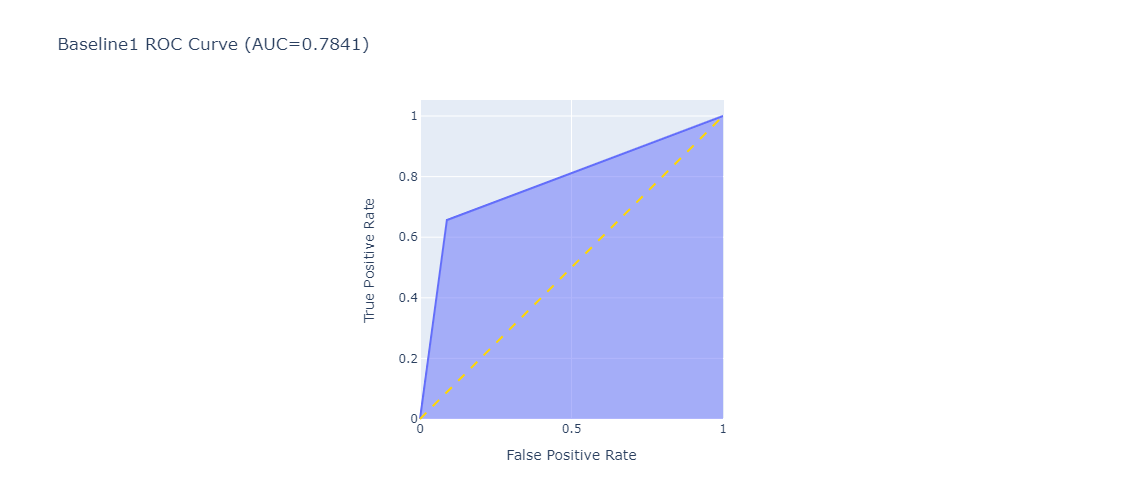

In [490]:
import plotly.express as px
from sklearn.metrics import roc_curve, auc
fpr, tpr, thresholds = roc_curve(y_test, b1_test_preds)
fig = px.area(
    x=fpr, y=tpr,
    title=f'Baseline1 ROC Curve (AUC={auc(fpr, tpr):.4f})',
    labels=dict(x='False Positive Rate', y='True Positive Rate'),
    width=700, height=500
)
fig.add_shape(
    type='line', line=dict(color="gold",dash='dash'),
    x0=0, x1=1, y0=0, y1=1
)

fig.update_yaxes(scaleanchor="x", scaleratio=1)
fig.update_xaxes(constrain='domain')
fig.show()

In [491]:
from sklearn.metrics import classification_report
print(pd.crosstab(y_test, b1_test_preds, rownames=["Actual"], colnames=["Predicted"]))
print(f"\n{classification_report(y_test, b1_test_preds)}")

Predicted    0    1
Actual             
0          845   82
1           91  174

              precision    recall  f1-score   support

           0       0.90      0.91      0.91       927
           1       0.68      0.66      0.67       265

    accuracy                           0.85      1192
   macro avg       0.79      0.78      0.79      1192
weighted avg       0.85      0.85      0.85      1192



### Baseline 1 Summary
The model was cross validated 5 times and tested 1 time, `random_state=42` was inserted to fix results (both splits and model):
* **Raw accuracy**: validation set had an impressive score of 85.82%, test set had 85.49% which is slightly lower but expected (no overfitting). cross validation reached 86.9%.
* **Auc**: validation set had a score of 0.769, test set had 0.7841 which is higher.
* **F1 score**: validation set had a score of 0.6515, test set had 0.668 which is higher.

The baseline is saved for comparison as a pandas dataframe: 

In [492]:
Baseline1 = pd.DataFrame({"val_acc": b1_val_score,"val_auc": b1_val_auc,"val_f1": b1_val_f1,
                          "test_acc": b1_test_score,"test_auc": b1_test_auc,"test_f1": b1_test_f1}, index=["Baseline1"])
Baseline1

,val_acc,val_auc,val_f1,test_acc,test_auc,test_f1
Baseline1,0.858221,0.76996,0.651546,0.854866,0.784073,0.667946


## Baseline 2: Scaling parameters and tuning hyper parameters

### Decisions:
* **Preprocessing:**
    1. **Missing data:** **Categoric** - fill with most frequent. **Discrete** - fill with most frequent. **Continuous** - fill with median.               
    2. **Feature Engineering**: categoric labels - one hot encoding, continuous parameters: standart scaling (z-score).
* **Model training** - using grid search in validation data on a decision tree model for maximizing "f1".
* **Model testing** - train on whole train + validation set and use test data for results.

**Preprocessing**

In [493]:
from sklearn.preprocessing import StandardScaler

# Preprocessing for continuous data
contiuous_transformer = Pipeline(steps=[
('imputer', SimpleImputer(strategy='median')),
('scaler', StandardScaler())
])

# Preprocessing for categorical data
categorical_transformer = Pipeline(steps=[
('imputer', SimpleImputer(strategy='most_frequent')),
('oh', OneHotEncoder())
])

# Preprocessing for discrete data
disc_transformer = SimpleImputer(strategy='median')  

# Create preprocessor
preprocessor = ColumnTransformer(
    transformers=[
        ('num', contiuous_transformer, Continuous+["LOAN"]),
        ('cat', categorical_transformer, Cats),
        ('disc', disc_transformer, Discrete)
    ])

**Model**

In [494]:
Baseline2 = Pipeline(steps=[('preprocessor', preprocessor),
                              ('model', model)
                             ])
Baseline2

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['MORTDUE', 'VALUE', 'CLAGE',
                                                   'DEBTINC', 'LOAN']),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('oh',
                                                                   OneHotEncoder())]),
         

**Grid Search CV**

The validation will be searched with 3 hyperparameters: `min_samples_leaf`, `max_features`, `max_depth` and `random_state = 42` for fixing results.

In [495]:
from sklearn.model_selection import GridSearchCV
hyperparameters = {"model__random_state":[42],"model__min_samples_leaf":[None,2,3,4],"model__max_features":[None,1,3,5],"model__max_depth":[None,1,3,5]}
b2_test_clf = GridSearchCV(Baseline2, hyperparameters,cv = 5, scoring = "f1", n_jobs = -1, verbose = 2)                   

**fit pipeline** 

The fit is executer with the following command: 
```python
%%time
``` 
This measures wall time (the time from the moment the system recived the command until it finished excecution)

In [496]:
%%time
# Fit and tune model
b2_test_clf.fit(X_train, y_train)

Fitting 5 folds for each of 64 candidates, totalling 320 fits
Wall time: 3.6 s


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(transformers=[('num',
                                                                         Pipeline(steps=[('imputer',
                                                                                          SimpleImputer(strategy='median')),
                                                                                         ('scaler',
                                                                                          StandardScaler())]),
                                                                         ['MORTDUE',
                                                                          'VALUE',
                                                                          'CLAGE',
                                                                          'DEBTINC',
                                                                        

**The Chosen Parameters**

In [497]:
b2_test_clf.best_params_

{'model__max_depth': 5,
 'model__max_features': None,
 'model__min_samples_leaf': 2,
 'model__random_state': 42}

**Validation Prediction**

In [498]:
b2_val_clf = b2_test_clf.best_estimator_
b2_val_clf.fit(X_train2, y_train2)
b2_val_preds = b2_val_clf.predict(X_val)

# Evaluate the model
b2_val_score = accuracy_score(y_val, b2_val_preds)
b2_val_auc = roc_auc_score(y_val, b2_val_preds)
b2_val_f1 = f1_score(y_val, b2_val_preds)

print('accuracy score:', b2_val_score)
print("roc auc score: ",b2_val_auc)
print("f1 score: ",b2_val_f1)

accuracy score: 0.8666107382550335
roc auc score:  0.7880043280134834
f1 score:  0.6774847870182557


**Test Prediction**

In [499]:
b2_test_preds = b2_test_clf.predict(X_test)

# Evaluate the model
b2_test_score = accuracy_score(y_test, b2_test_preds)
b2_test_auc = roc_auc_score(y_test, b2_test_preds)
b2_test_f1 = f1_score(y_test, b2_test_preds)

print('accuracy score:', b2_test_score)
print("roc auc score: ",b2_test_auc)
print("f1 score: ",b2_test_f1)

accuracy score: 0.8758389261744967
roc auc score:  0.8110317314933545
f1 score:  0.7131782945736432


**Area Under Curve plot**

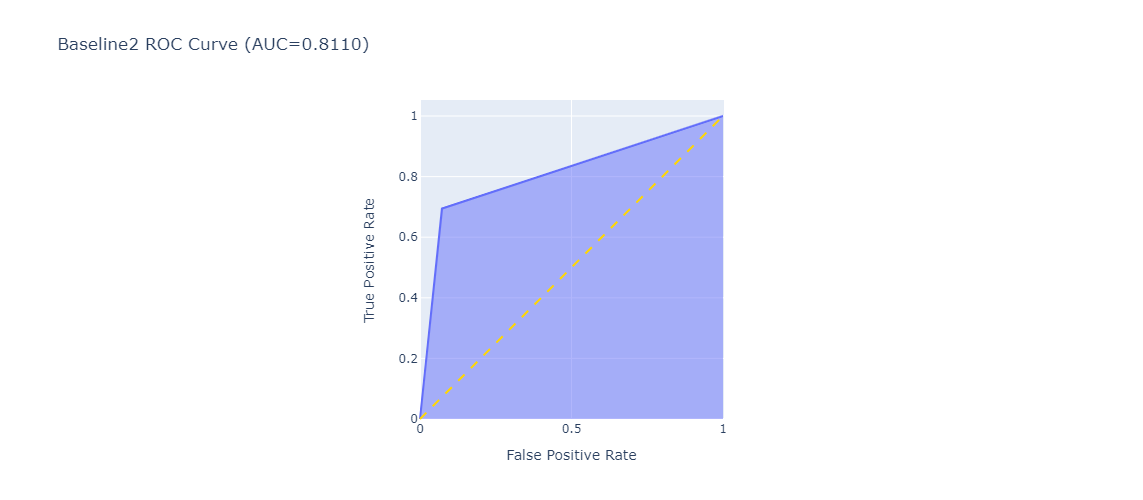

In [500]:
fpr, tpr, thresholds = roc_curve(y_test, b2_test_preds)
fig = px.area(
    x=fpr, y=tpr,
    title=f'Baseline2 ROC Curve (AUC={auc(fpr, tpr):.4f})',
    labels=dict(x='False Positive Rate', y='True Positive Rate'),
    width=700, height=500
)
fig.add_shape(
    type='line', line=dict(color="gold",dash='dash'),
    x0=0, x1=1, y0=0, y1=1
)

fig.update_yaxes(scaleanchor="x", scaleratio=1)
fig.update_xaxes(constrain='domain')
fig.show()

In [501]:
print(pd.crosstab(y_test, b2_test_preds, rownames=["Actual"], colnames=["Predicted"]))
print(f"\n{classification_report(y_test, b2_test_preds)}")

Predicted    0    1
Actual             
0          860   67
1           81  184

              precision    recall  f1-score   support

           0       0.91      0.93      0.92       927
           1       0.73      0.69      0.71       265

    accuracy                           0.88      1192
   macro avg       0.82      0.81      0.82      1192
weighted avg       0.87      0.88      0.87      1192



### Baseline 2 Summary
The Pipeline was cross validated 5 times then predicted with original validation set and then predicted test set 1 time, `random_state=42` was inserted to fix results (both splits and model):
* **Raw accuracy**: validation set had a score of 86.68%, test set had 87.58% which is an impressive improvement from the first baseline.
* **Auc**: validation set had a score of 0.788, test set had 0.811 which is significantly higher.
* **F1 score**: validation set had a score of 0.6775, test set had 0.7132 which is significantly higher.

The baseline is saved for comparison as a pandas dataframe

In [502]:
Baseline2 = pd.DataFrame({"val_acc": b2_val_score,"val_auc": b2_val_auc,"val_f1": b2_val_f1,
                          "test_acc": b2_test_score,"test_auc": b2_test_auc,"test_f1": b2_test_f1}, index=["Baseline2"])
Baseline2

,val_acc,val_auc,val_f1,test_acc,test_auc,test_f1
Baseline2,0.866611,0.788004,0.677485,0.875839,0.811032,0.713178


The baslines dataframe is created for comparisons: 

In [503]:
Baselines = pd.concat([Baseline1,Baseline2])
Baselines

,val_acc,val_auc,val_f1,test_acc,test_auc,test_f1
Baseline1,0.858221,0.769960,0.651546,0.854866,0.784073,0.667946
Baseline2,0.866611,0.788004,0.677485,0.875839,0.811032,0.713178


## Baseline 3: tuning preprocessing parameters, Decision between A few models. 

### Decisions:
* **Preprocessing:**
    1. **Missing data:** hyperparamer tune.               
    2. **Feature Engineering**: categoric labels - one hot encoding, continuous parameters: standart scaling (z-score).
* **Model training** - using grid search in validation data on a 5 models for maximizing "f1".
* **Model testing** - train on whole train + validation set and use test data for results.

**Preprocessing**

In [504]:
# Preprocessing for continuous data
contiuous_transformer = Pipeline(steps=[
('imputer', SimpleImputer()),
('scaler', StandardScaler())
])

# Preprocessing for categorical data
categorical_transformer = Pipeline(steps=[
('imputer', SimpleImputer(strategy='most_frequent')),
('oh', OneHotEncoder())
])

# Preprocessing for discrete data
disc_transformer = Pipeline(steps=[
('imputer', SimpleImputer()),
('scaler', StandardScaler())
])    

# Create preprocessor
preprocessor = ColumnTransformer(
    transformers=[
        ('num', contiuous_transformer, Continuous+["LOAN"]),
        ('cat', categorical_transformer, Cats),
        ('disc', disc_transformer, Discrete)
    ])

**Model**

In [505]:
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC 
Baseline3 = Pipeline(steps=[('preprocessor', preprocessor),
                              ('model', PipelineHelper([('svc', SVC(random_state = 42)),
                                   ('lr', LogisticRegression(random_state = 42)),
                                   ('dt', DecisionTreeClassifier(random_state = 42)),
                                   ('gnb', GaussianNB()),
                                   ('knn', KNeighborsClassifier()),
                                                       ]))
                             ])
Baseline3

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer()),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['MORTDUE', 'VALUE', 'CLAGE',
                                                   'DEBTINC', 'LOAN']),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('oh',
                                                                   OneHotEncoder())]),
                          

In [506]:
Baseline3.get_params().keys()

dict_keys(['memory', 'steps', 'verbose', 'preprocessor', 'model', 'preprocessor__n_jobs', 'preprocessor__remainder', 'preprocessor__sparse_threshold', 'preprocessor__transformer_weights', 'preprocessor__transformers', 'preprocessor__verbose', 'preprocessor__num', 'preprocessor__cat', 'preprocessor__disc', 'preprocessor__num__memory', 'preprocessor__num__steps', 'preprocessor__num__verbose', 'preprocessor__num__imputer', 'preprocessor__num__scaler', 'preprocessor__num__imputer__add_indicator', 'preprocessor__num__imputer__copy', 'preprocessor__num__imputer__fill_value', 'preprocessor__num__imputer__missing_values', 'preprocessor__num__imputer__strategy', 'preprocessor__num__imputer__verbose', 'preprocessor__num__scaler__copy', 'preprocessor__num__scaler__with_mean', 'preprocessor__num__scaler__with_std', 'preprocessor__cat__memory', 'preprocessor__cat__steps', 'preprocessor__cat__verbose', 'preprocessor__cat__imputer', 'preprocessor__cat__oh', 'preprocessor__cat__imputer__add_indicator'

**Grid Search CV**

The validation will be searched with 5 models: GaussianNB, LogisticRegression, KNeighborsClassifier, SVC  and DecisionTreeClassifier.
`random_state = 42` is inserted for fixing results.

In [507]:
hyperparameters = { 
                   'preprocessor__num__imputer__strategy': ['mean', 'median'],
                    'preprocessor__cat__imputer__strategy': ['constant', 'most_frequent'],
                    'preprocessor__disc__imputer__strategy': ['mean', 'median'],
                    'model__selected_model': Baseline3.named_steps['model'].generate({   
                    'svc__C': [0.1,0.5,1],
                    'lr__C': np.logspace(-4, 4, 10),
                    'lr__solver': ["lbfgs", "liblinear"],   
                    'dt__max_depth': [None,1,3,5,],
                    'dt__max_features':  [None,1,3,5],
                    'dt__min_samples_leaf':  [None,2,3,4],
                    'knn__n_neighbors': [2,4,6,8],
                    'gnb__var_smoothing': np.logspace(0,-9, num=10)                       
    })}

In [508]:
b3_test_clf = GridSearchCV(Baseline3, hyperparameters,cv = 5, scoring = "f1", n_jobs = -1, verbose = 2) 

**fit pipeline** 

In [509]:
%%time
# Fit and tune model
b3_test_clf.fit(X_train, y_train)

Fitting 5 folds for each of 808 candidates, totalling 4040 fits
Wall time: 33.2 s


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(transformers=[('num',
                                                                         Pipeline(steps=[('imputer',
                                                                                          SimpleImputer()),
                                                                                         ('scaler',
                                                                                          StandardScaler())]),
                                                                         ['MORTDUE',
                                                                          'VALUE',
                                                                          'CLAGE',
                                                                          'DEBTINC',
                                                                          'LOAN']),
     

**The Chosen Parameters**

In [510]:
b3_test_clf.best_params_

{'model__selected_model': ('dt',
  {'max_depth': 5, 'max_features': None, 'min_samples_leaf': 2}),
 'preprocessor__cat__imputer__strategy': 'constant',
 'preprocessor__disc__imputer__strategy': 'mean',
 'preprocessor__num__imputer__strategy': 'mean'}

**Validation Prediction**

In [511]:
b3_val_clf = b3_test_clf.best_estimator_
b3_val_clf.fit(X_train2, y_train2)
b3_val_preds = b3_val_clf.predict(X_val)

# Evaluate the model
b3_val_score = accuracy_score(y_val, b3_val_preds)
b3_val_auc = roc_auc_score(y_val, b3_val_preds)
b3_val_f1 = f1_score(y_val, b3_val_preds)

print('accuracy score:', b3_val_score)
print("roc auc score: ",b3_val_auc)
print("f1 score: ",b3_val_f1)

accuracy score: 0.87751677852349
roc auc score:  0.8118853908737177
f1 score:  0.7103174603174603


**Test Prediction**

In [512]:
b3_test_preds = b3_test_clf.predict(X_test)

# Evaluate the model
b3_test_score = accuracy_score(y_test, b3_test_preds)
b3_test_auc = roc_auc_score(y_test, b3_test_preds)
b3_test_f1 = f1_score(y_test, b3_test_preds)

print('accuracy score:', b3_test_score)
print("roc auc score: ",b3_test_auc)
print("f1 score: ",b3_test_f1)

accuracy score: 0.8850671140939598
roc auc score:  0.8210071034581018
f1 score:  0.7318982387475538


**Area Under Curve plot**

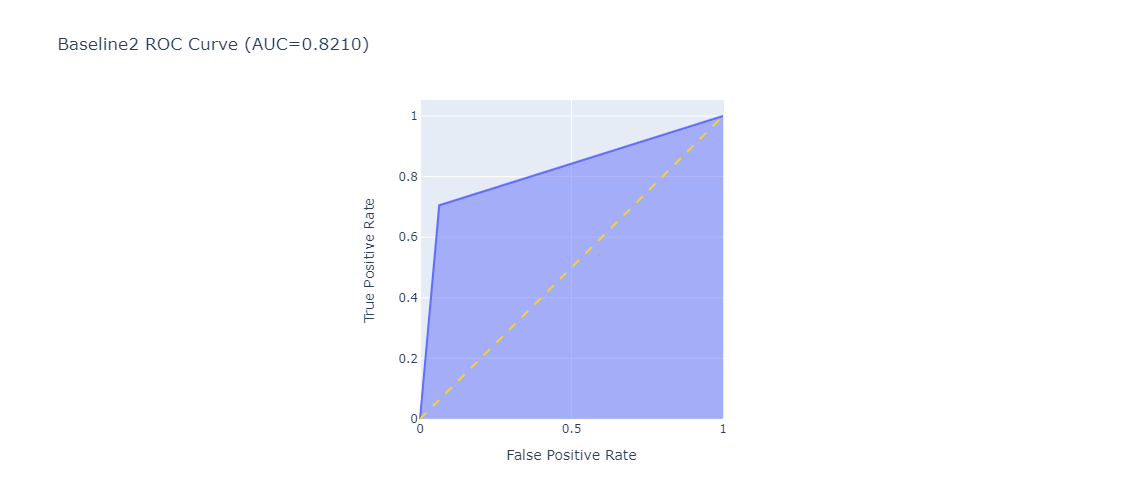

In [513]:
fpr, tpr, thresholds = roc_curve(y_test, b3_test_preds)
fig = px.area(
    x=fpr, y=tpr,
    title=f'Baseline2 ROC Curve (AUC={auc(fpr, tpr):.4f})',
    labels=dict(x='False Positive Rate', y='True Positive Rate'),
    width=700, height=500
)
fig.add_shape(
    type='line', line=dict(color="gold",dash='dash'),
    x0=0, x1=1, y0=0, y1=1
)

fig.update_yaxes(scaleanchor="x", scaleratio=1)
fig.update_xaxes(constrain='domain')
fig.show()

In [514]:
print(pd.crosstab(y_test, b3_test_preds, rownames=["Actual"], colnames=["Predicted"]))
print(f"\n{classification_report(y_test, b3_test_preds)}")

Predicted    0    1
Actual             
0          868   59
1           78  187

              precision    recall  f1-score   support

           0       0.92      0.94      0.93       927
           1       0.76      0.71      0.73       265

    accuracy                           0.89      1192
   macro avg       0.84      0.82      0.83      1192
weighted avg       0.88      0.89      0.88      1192



### Baseline 3 Summary
The Pipeline was cross validated 5 times then predicted with original validation set and then predicted test set 1 time, `random_state=42` was inserted to fix results (both splits and model):
* **Raw accuracy**: validation set had a score of 87.75%, test set had 88.51% which is an impressive improvement from the second baseline.
* **Auc**: validation set had a score of 0.811, test set had 0.821 which is higher than the second baseline.
* **F1 score**: validation set had a score of 0.7103, test set had 0.7319 which is higher than the second baseline..

The baseline is saved for comparison as a pandas dataframe

In [515]:
Baseline3 = pd.DataFrame({"val_acc": b3_val_score,"val_auc": b3_val_auc,"val_f1": b3_val_f1,
                          "test_acc": b3_test_score,"test_auc": b3_test_auc,"test_f1": b3_test_f1}, index=["Baseline3"])
Baseline3

,val_acc,val_auc,val_f1,test_acc,test_auc,test_f1
Baseline3,0.877517,0.811885,0.710317,0.885067,0.821007,0.731898


The baseline is added to the baselines dataframe: 

In [516]:
Baselines = pd.concat([Baselines,Baseline3])
Baselines

,val_acc,val_auc,val_f1,test_acc,test_auc,test_f1
Baseline1,0.858221,0.769960,0.651546,0.854866,0.784073,0.667946
Baseline2,0.866611,0.788004,0.677485,0.875839,0.811032,0.713178
Baseline3,0.877517,0.811885,0.710317,0.885067,0.821007,0.731898


## Baseline 4: Random Forest, Gradient Boosting and Voting Classifier. 

### Decisions:
* **Preprocessing:**
    1. **Missing data:** hyperparamer tune.               
    2. **Feature Engineering**: categoric labels - one hot encoding, continuous parameters: standart scaling (z-score).
* **Model training** - using grid search in validation data on a 3 diffrent ensemble models for maximizing "f1".
* **Model testing** - train on whole train + validation set and use test data for results.

In [517]:
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from xgboost import XGBClassifier

clf1 = LogisticRegression(random_state=42)
clf2 = SVC(random_state=42)
clf3 = GaussianNB()
eclf = VotingClassifier(estimators=[('lr', clf1), ('svc', clf2), ('gnb', clf3)], voting='hard')

RF = RandomForestClassifier(random_state=42)

XGB = XGBClassifier(eval_metric='binary:logistic')

Baseline4 = Pipeline(steps=[('preprocessor', preprocessor),
                              ('model', PipelineHelper([('eclf', eclf),
                                   ('rf', RF),
                                   ('xgb', XGB)
                                                       ]))
                             ])
Baseline4

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer()),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['MORTDUE', 'VALUE', 'CLAGE',
                                                   'DEBTINC', 'LOAN']),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('oh',
                                                                   OneHotEncoder())]),
                          

In [518]:
Baseline4.get_params().keys()

dict_keys(['memory', 'steps', 'verbose', 'preprocessor', 'model', 'preprocessor__n_jobs', 'preprocessor__remainder', 'preprocessor__sparse_threshold', 'preprocessor__transformer_weights', 'preprocessor__transformers', 'preprocessor__verbose', 'preprocessor__num', 'preprocessor__cat', 'preprocessor__disc', 'preprocessor__num__memory', 'preprocessor__num__steps', 'preprocessor__num__verbose', 'preprocessor__num__imputer', 'preprocessor__num__scaler', 'preprocessor__num__imputer__add_indicator', 'preprocessor__num__imputer__copy', 'preprocessor__num__imputer__fill_value', 'preprocessor__num__imputer__missing_values', 'preprocessor__num__imputer__strategy', 'preprocessor__num__imputer__verbose', 'preprocessor__num__scaler__copy', 'preprocessor__num__scaler__with_mean', 'preprocessor__num__scaler__with_std', 'preprocessor__cat__memory', 'preprocessor__cat__steps', 'preprocessor__cat__verbose', 'preprocessor__cat__imputer', 'preprocessor__cat__oh', 'preprocessor__cat__imputer__add_indicator'

**Grid Search CV**

The validation will be searched with 3 ensembel models: RandomForestClassifier, VotingClassifier(SCV,LR,GNB) and XGBoostClassifier.
`random_state = 42` is inserted for fixing results.

In [519]:
hyperparameters = { 
                   'preprocessor__num__imputer__strategy': ['mean', 'median'],
                    'preprocessor__cat__imputer__strategy': ['constant', 'most_frequent'],
                    'preprocessor__disc__imputer__strategy': ['mean', 'median'],
                    'model__selected_model': Baseline4.named_steps['model'].generate({
                    'eclf__voting' : ["soft","hard"],    
                    'eclf__svc__C': [0.1,0.5,1],
                    'eclf__lr__C': np.logspace(-4, 4, 5),
                    'eclf__lr__solver': ["lbfgs", "liblinear"],
                    'eclf__gnb__var_smoothing': np.logspace(0,-9, num=5),    
                    'rf__criterion': ["gini","entropy"],    
                    'rf__n_estimators': [50,100,200],
                    'rf__max_features':  [1,3,5],
                    'rf__min_samples_leaf':  [2,3,4],
                    'xgb__max_depth': [5,6],
                    'xgb__min_child_weight': [5,6]    
                                                
    })}

**fit pipeline** 

In [520]:
b4_test_clf = GridSearchCV(Baseline4, hyperparameters,cv = 5, scoring = "f1", n_jobs = -1, verbose = 2) 

In [521]:
%%time
# Fit and tune model
b4_test_clf.fit(X_train, y_train)

Fitting 5 folds for each of 2864 candidates, totalling 14320 fits
Wall time: 16min 28s


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(transformers=[('num',
                                                                         Pipeline(steps=[('imputer',
                                                                                          SimpleImputer()),
                                                                                         ('scaler',
                                                                                          StandardScaler())]),
                                                                         ['MORTDUE',
                                                                          'VALUE',
                                                                          'CLAGE',
                                                                          'DEBTINC',
                                                                          'LOAN']),
     

**The Chosen Parameters**

In [522]:
b4_test_clf.best_params_

{'model__selected_model': ('rf',
  {'criterion': 'gini',
   'max_features': 5,
   'min_samples_leaf': 2,
   'n_estimators': 200}),
 'preprocessor__cat__imputer__strategy': 'constant',
 'preprocessor__disc__imputer__strategy': 'median',
 'preprocessor__num__imputer__strategy': 'mean'}

**Validation Prediction**

In [523]:
b4_val_clf = b4_test_clf.best_estimator_
b4_val_clf.fit(X_train2, y_train2)
b4_val_preds = b4_val_clf.predict(X_val)

# Evaluate the model
b4_val_score = accuracy_score(y_val, b4_val_preds)
b4_val_auc = roc_auc_score(y_val, b4_val_preds)
b4_val_f1 = f1_score(y_val, b4_val_preds)

print('accuracy score:', b4_val_score)
print("roc auc score: ",b4_val_auc)
print("f1 score: ",b4_val_f1)

accuracy score: 0.9035234899328859
roc auc score:  0.8058906760440292
f1 score:  0.7392290249433107


**Test Prediction**

In [524]:
b4_test_preds = b4_test_clf.predict(X_test)

# Evaluate the model
b4_test_score = accuracy_score(y_test, b4_test_preds)
b4_test_auc = roc_auc_score(y_test, b4_test_preds)
b4_test_f1 = f1_score(y_test, b4_test_preds)

print('accuracy score:', b4_test_score)
print("roc auc score: ",b4_test_auc)
print("f1 score: ",b4_test_f1)

accuracy score: 0.9060402684563759
roc auc score:  0.8196698622051249
f1 score:  0.7586206896551724


**Area Under Curve plot**

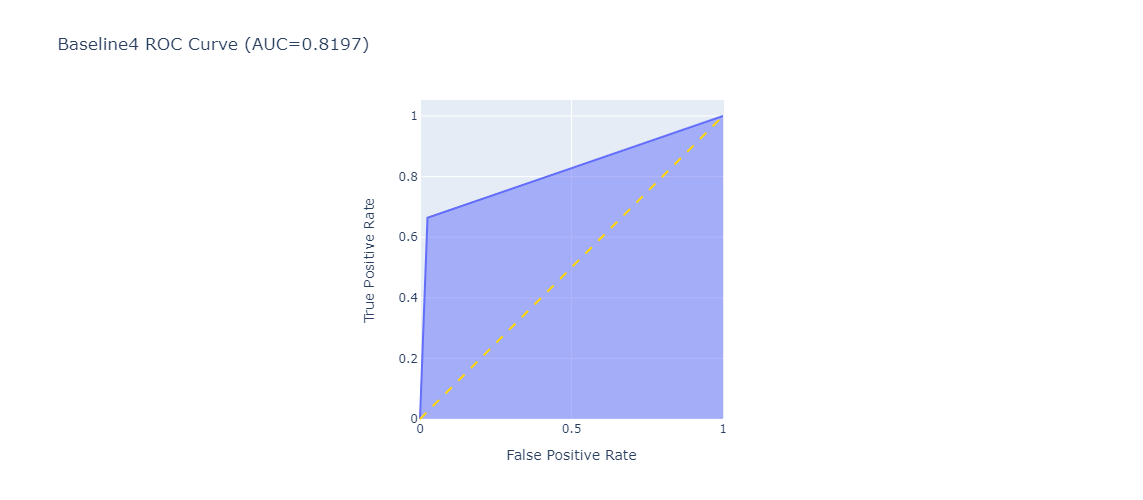

In [525]:
fpr, tpr, thresholds = roc_curve(y_test, b4_test_preds)
fig = px.area(
    x=fpr, y=tpr,
    title=f'Baseline4 ROC Curve (AUC={auc(fpr, tpr):.4f})',
    labels=dict(x='False Positive Rate', y='True Positive Rate'),
    width=700, height=500
)
fig.add_shape(
    type='line', line=dict(color="gold",dash='dash'),
    x0=0, x1=1, y0=0, y1=1
)

fig.update_yaxes(scaleanchor="x", scaleratio=1)
fig.update_xaxes(constrain='domain')
fig.show()

In [526]:
print(pd.crosstab(y_test, b4_test_preds, rownames=["Actual"], colnames=["Predicted"]))
print(f"\n{classification_report(y_test, b4_test_preds)}")

Predicted    0    1
Actual             
0          904   23
1           89  176

              precision    recall  f1-score   support

           0       0.91      0.98      0.94       927
           1       0.88      0.66      0.76       265

    accuracy                           0.91      1192
   macro avg       0.90      0.82      0.85      1192
weighted avg       0.90      0.91      0.90      1192



### Baseline 4 Summary
The Pipeline was cross validated 5 times then predicted with original validation set and then predicted test set 1 time, `random_state=42` was inserted to fix results (both splits and model):
* **Raw accuracy**: validation set had a score of 90.35%, test set had 90.6% which is an amazing improvement from the third baseline.
* **Auc**: validation set had a score of 0.8059, test set had 0.8197 which is slightly lower than the third baseline.
* **F1 score**: validation set had a score of 0.7392, test set had 0.7586 which is higher than the third baseline.

The baseline is saved for comparison as a pandas dataframe

In [527]:
Baseline4 = pd.DataFrame({"val_acc": b4_val_score,"val_auc": b4_val_auc,"val_f1": b4_val_f1,
                          "test_acc": b4_test_score,"test_auc": b4_test_auc,"test_f1": b4_test_f1}, index=["Baseline4"])
Baseline4

,val_acc,val_auc,val_f1,test_acc,test_auc,test_f1
Baseline4,0.903523,0.805891,0.739229,0.90604,0.81967,0.758621


The baseline is added to the baselines dataframe: 

In [528]:
Baselines = pd.concat([Baseline1,Baseline2,Baseline3,Baseline4])
Baselines

,val_acc,val_auc,val_f1,test_acc,test_auc,test_f1
Baseline1,0.858221,0.769960,0.651546,0.854866,0.784073,0.667946
Baseline2,0.866611,0.788004,0.677485,0.875839,0.811032,0.713178
Baseline3,0.877517,0.811885,0.710317,0.885067,0.821007,0.731898
Baseline4,0.903523,0.805891,0.739229,0.906040,0.819670,0.758621


## Baseline 5: Deep Learning Self made fully connected neural network. 

### Decisions:
* **Preprocessing:**
    1. **Missing data:** hyperparamer tune.               
    2. **Feature Engineering**: categoric labels - one hot encoding, continuous parameters: standart scaling (z-score).
* **Model training** - creating a binary classification neural network.
* **Model testing** - train on whole train + validation set(only once, no grid search) and use test data for results.

In [529]:
# Classification neural network
import numpy as np
# Preprocessing for continuous data use best settings from the previus baseline preprocessor grid search
contiuous_transformer = Pipeline(steps=[
('imputer', SimpleImputer(strategy='mean')),
('scaler', StandardScaler())
])

# Preprocessing for categorical data
categorical_transformer = Pipeline(steps=[
('imputer', SimpleImputer(strategy='constant')),
('oh', OneHotEncoder())
])

# Preprocessing for discrete data
disc_transformer = Pipeline(steps=[
                    ('imputer',SimpleImputer(strategy='median')),
                    ('scaler', StandardScaler())
    ])

# Create preprocessor
preprocessor = ColumnTransformer(
    transformers=[
        ('num', contiuous_transformer, Continuous+["LOAN"]),
        ('cat', categorical_transformer, Cats),
        ('disc', disc_transformer, Discrete)
    ])
#preprocess
preprocess = Pipeline(steps = [('preprocess', preprocessor)])

#make numpy arrays of all sets with the preprocessor using the fit_transform method


#validation set
b5_X_train2 = preprocess.fit_transform(X_train2)
b5_X_val = preprocess.fit_transform(X_val)
b5_y_train2 =y_train2.to_numpy()
b5_y_val = y_val

#test set
b5_X_train = preprocess.fit_transform(X_train)
b5_X_test = preprocess.fit_transform(X_test)
b5_y_train = y_train.to_numpy()
b5_y_test = y_test.to_numpy()

### The net:
![](https://1.cms.s81c.com/sites/default/files/2021-01-06/ICLH_Diagram_Batch_01_03-DeepNeuralNetwork-WHITEBG.png)
The net is a simple fully connected neural network with this structure:
* **input layer (18 inputs)**: the numerric and discrete features, the one hot encoded categoric features:
* **first hidden layer**: 100 neurons + relu activation.
* **second hidden layer**: 50 neurons + relu activation.
* **third hidden layer**: 25 neurons + relu activation.
* **output layer**:  one neuron + sigmoid activation function input is finally the probabilty of being a defaulter (label 1) and then decides if it is a defaulter.

the process (each iteration):
1. random weights are initiated for input layer (random seed 42 is initiated to fix results)
2. the forward method for each layer is activated until it produces the output defined above.
3. the network compares initial outputs with the target.
4. the binary cross entropy loss function is used to modify initial outputs based on the degree to which they differed from the target values.
5. finally, backpropegation is initialized for weights and bias updates with the adam optimizer, (learning rate adjustet to 0.01).

the process is going through the data 1000 times to find the optimal minimum of the loss function to find the best result for the task.

In [530]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
import random
#activate gpu in device
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# randomness fix
manualSeed = 42

np.random.seed(manualSeed)
random.seed(manualSeed)

## if you are suing GPU
torch.manual_seed(manualSeed)
torch.cuda.manual_seed(manualSeed)
torch.cuda.manual_seed_all(manualSeed)
torch.backends.cudnn.enabled = False
torch.backends.cudnn.benchmark = False
torch.backends.cudnn.deterministic = True


#convert to torch tensors

#validation set
b5_X_train2 = Variable(torch.Tensor(b5_X_train2).float())
b5_X_val = Variable(torch.Tensor(b5_X_val).float())
b5_y_train2 = Variable(torch.Tensor(b5_y_train2).float())
b5_y_val = Variable(torch.Tensor(b5_y_val).float())

#test set
b5_X_train = Variable(torch.Tensor(b5_X_train).float())
b5_X_test = Variable(torch.Tensor(b5_X_test).float())
b5_y_train = Variable(torch.Tensor(b5_y_train).float())
b5_y_test = Variable(torch.Tensor(b5_y_test).float())



#the neural networks
class Net(nn.Module):
    
    def __init__(self,in_count,output_count):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(in_count,100)
        self.fc2 = nn.Linear(100,50)
        self.fc3 = nn.Linear(50,25)
        self.fc4 = nn.Linear(25,output_count)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        x = self.fc3(x)
        x = self.fc4(x)
        out = self.sigmoid(x)
        return out

#initiate network
net = Net(b5_X_train2.shape[1],1)

criterion = nn.BCELoss()# binary cross entropy loss
optimizer = torch.optim.Adam(net.parameters(), lr=0.01)#optimizer

for epoch in range(1000):
    optimizer.zero_grad()
    out = net(b5_X_train2)
    loss = criterion(out, b5_y_train2.unsqueeze(1))
    loss.backward()
    optimizer.step()
    
    if epoch % 50 == 0:
        print(f"Epoch {epoch}, loss: {loss.item()}")

Epoch 0, loss: 0.7315994501113892
Epoch 50, loss: 0.20670698583126068
Epoch 100, loss: 0.06770513951778412
Epoch 150, loss: 0.03323780745267868
Epoch 200, loss: 0.006445864215493202
Epoch 250, loss: 0.0020603304728865623
Epoch 300, loss: 0.0009721651440486312
Epoch 350, loss: 0.0005732585559599102
Epoch 400, loss: 0.00038013915764167905
Epoch 450, loss: 0.0002708499087020755
Epoch 500, loss: 0.0002035043726209551
Epoch 550, loss: 0.00015824014553800225
Epoch 600, loss: 0.00012677174527198076
Epoch 650, loss: 0.00010376526188338175
Epoch 700, loss: 8.647826325614005e-05
Epoch 750, loss: 7.315317634493113e-05
Epoch 800, loss: 6.26709297648631e-05
Epoch 850, loss: 5.426146890386008e-05
Epoch 900, loss: 4.740718941320665e-05
Epoch 950, loss: 4.1738803702173755e-05


In [531]:
np.set_printoptions(suppress=True)#supress scientific notation

b5_pred = net(b5_X_val)#prediction

b5_pred = b5_pred.detach().numpy()#numpy convertion
b5_pred = np.where(b5_pred<0.5,0,1)#convert to predictions

b5_pred = b5_pred.reshape(-1) #reshape to one numpy array
b5_pred = torch.Tensor(b5_pred)# convert to tensor
b5_pred.shape

torch.Size([1192])

In [532]:
b5_y_val.shape

torch.Size([1192])

**Validation Prediction**

In [533]:
# Evaluate the model
b5_val_score = accuracy_score(b5_y_val, b5_pred)
b5_val_auc = roc_auc_score(b5_y_val, b5_pred)
b5_val_f1 = f1_score(b5_y_val, b5_pred)

print('accuracy score:', b5_val_score)
print("roc auc score: ",b5_val_auc)
print("f1 score: ",b5_val_f1)

accuracy score: 0.9177852348993288
roc auc score:  0.8474292016063588
f1 score:  0.7914893617021277


In [534]:
np.random.seed(manualSeed)
random.seed(manualSeed)

## if you are suing GPU
torch.manual_seed(manualSeed)
torch.cuda.manual_seed(manualSeed)
torch.cuda.manual_seed_all(manualSeed)
torch.backends.cudnn.enabled = False
torch.backends.cudnn.benchmark = False
torch.backends.cudnn.deterministic = True

#initiate network
net = Net(b5_X_train.shape[1],1)

criterion = nn.BCELoss()# binary cross entropy loss
optimizer = torch.optim.Adam(net.parameters(), lr=0.01)#optimizer

for epoch in range(1000):
    optimizer.zero_grad()
    out = net(b5_X_train)
    loss = criterion(out, b5_y_train.unsqueeze(1))
    loss.backward()
    optimizer.step()
    
    if epoch % 50 == 0:
        print(f"Epoch {epoch}, loss: {loss.item()}")

Epoch 0, loss: 0.7307356595993042
Epoch 50, loss: 0.2359730303287506
Epoch 100, loss: 0.09206192195415497
Epoch 150, loss: 0.1346876472234726
Epoch 200, loss: 0.03521254286170006
Epoch 250, loss: 0.012118685990571976
Epoch 300, loss: 0.004964006133377552
Epoch 350, loss: 0.002193722641095519
Epoch 400, loss: 0.0012108905939385295
Epoch 450, loss: 0.0007776409038342535
Epoch 500, loss: 0.0005507414462044835
Epoch 550, loss: 0.00041148377931676805
Epoch 600, loss: 0.00032031696173362434
Epoch 650, loss: 0.00025695899967104197
Epoch 700, loss: 0.00021119185839779675
Epoch 750, loss: 0.00017673301044851542
Epoch 800, loss: 0.00014987883332651109
Epoch 850, loss: 0.00012867141049355268
Epoch 900, loss: 0.0001116944185923785
Epoch 950, loss: 9.789881005417556e-05


In [535]:
np.set_printoptions(suppress=True)#supress scientific notation

b5_test_pred = net(b5_X_test)#prediction

b5_test_pred = b5_test_pred.detach().numpy()#numpy convertion
b5_test_pred = np.where(b5_test_pred<0.5,0,1)#convert to predictions

b5_test_pred = b5_test_pred.reshape(-1) #reshape to one numpy array
b5_test_pred = torch.Tensor(b5_test_pred)# convert to tensor
b5_test_pred.shape

torch.Size([1192])

**Test Prediction**

In [536]:
# Evaluate the model
b5_test_score = accuracy_score(b5_y_test, b5_test_pred)
b5_test_auc = roc_auc_score(b5_y_test, b5_test_pred)
b5_test_f1 = f1_score(b5_y_test, b5_test_pred)

print('accuracy score:', b5_test_score)
print("roc auc score: ",b5_test_auc)
print("f1 score: ",b5_test_f1)

accuracy score: 0.9077181208053692
roc auc score:  0.8342227921271702
f1 score:  0.7717842323651453


**Area Under Curve plot**

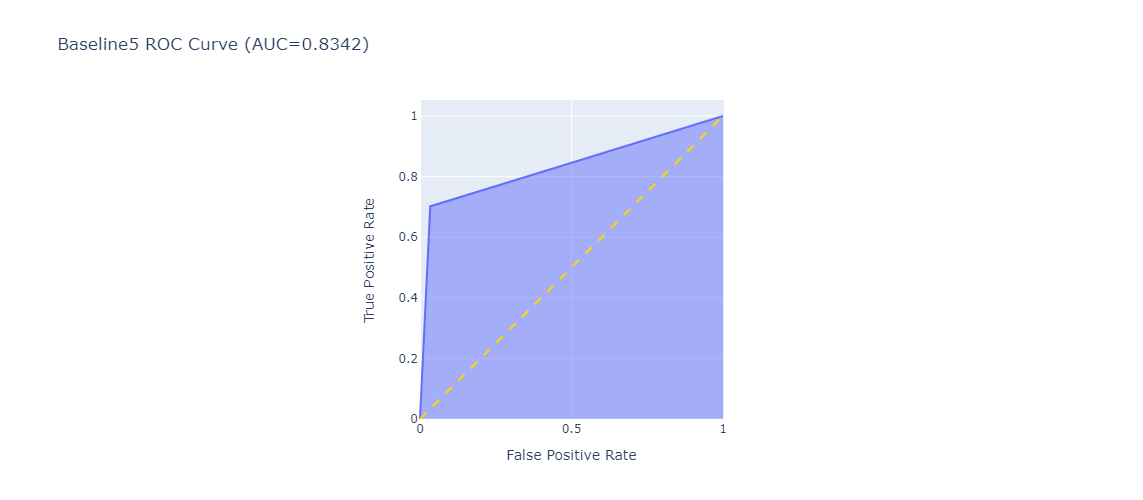

In [537]:
fpr, tpr, thresholds = roc_curve(b5_y_test, b5_test_pred)
fig = px.area(
    x=fpr, y=tpr,
    title=f'Baseline5 ROC Curve (AUC={auc(fpr, tpr):.4f})',
    labels=dict(x='False Positive Rate', y='True Positive Rate'),
    width=700, height=500
)
fig.add_shape(
    type='line', line=dict(color="gold",dash='dash'),
    x0=0, x1=1, y0=0, y1=1
)

fig.update_yaxes(scaleanchor="x", scaleratio=1)
fig.update_xaxes(constrain='domain')
fig.show()

In [538]:
print(pd.crosstab(b5_y_test, b5_test_pred, rownames=["Actual"], colnames=["Predicted"]))
print(f"\n{classification_report(y_test, b5_test_pred)}")

Predicted  0.0  1.0
Actual             
0.0        896   31
1.0         79  186

              precision    recall  f1-score   support

           0       0.92      0.97      0.94       927
           1       0.86      0.70      0.77       265

    accuracy                           0.91      1192
   macro avg       0.89      0.83      0.86      1192
weighted avg       0.91      0.91      0.90      1192



### Baseline 5 Summary
The Deep Learning model was tested on validation data and than predicted with original validation set and then predicted test set, `manualSeed=42` was inserted to fix results:
* **Raw accuracy**: validation set had a score of 91.77%, test set had 90.77% which is a slight improvement from the fourth baseline.
* **Auc**: validation set had a score of 0.8474 , test set had 0.8342 which is higher than the third baseline that was the highest so far.
* **F1 score**: validation set had a score of 0.7915, test set had 0.7718 which is higher than the fourth baseline.

The baseline is saved for comparison as a pandas dataframe:

In [539]:
Baseline5 = pd.DataFrame({"val_acc": b5_val_score,"val_auc": b5_val_auc,"val_f1": b5_val_f1,
                          "test_acc": b5_test_score,"test_auc": b5_test_auc,"test_f1": b5_test_f1}, index=["Baseline5"])
Baseline5

,val_acc,val_auc,val_f1,test_acc,test_auc,test_f1
Baseline5,0.917785,0.847429,0.791489,0.907718,0.834223,0.771784


The baseline is added to the rest of the baselines:

In [540]:
Baselines = pd.concat([Baseline1,Baseline2,Baseline3,Baseline4,Baseline5])
Baselines

,val_acc,val_auc,val_f1,test_acc,test_auc,test_f1
Baseline1,0.858221,0.769960,0.651546,0.854866,0.784073,0.667946
Baseline2,0.866611,0.788004,0.677485,0.875839,0.811032,0.713178
Baseline3,0.877517,0.811885,0.710317,0.885067,0.821007,0.731898
Baseline4,0.903523,0.805891,0.739229,0.906040,0.819670,0.758621
Baseline5,0.917785,0.847429,0.791489,0.907718,0.834223,0.771784


## Baseline 6: Deep Learning Tabnet. 

### Decisions:
* **Preprocessing:**
    1. **Missing data:** hyperparamer tune.               
    2. **Feature Engineering**: categoric labels - one hot encoding, continuous parameters: standart scaling (z-score).
* **Model training** - creating a binary classification neural network.
* **Model testing** - train on whole train + validation set and use test data for results.

In [541]:
from pytorch_tabnet.tab_model import TabNetClassifier
TBN = TabNetClassifier(verbose=0,seed=42)

## TabNet Structure:
![](https://miro.medium.com/max/2000/1*PCyFIs8ce-a5j4caAhJiVg.png)
For more information on this amazing net available [here](https://arxiv.org/pdf/1908.07442.pdf).

In [542]:
%%time
#validation set
b6_X_train2 = preprocess.fit_transform(X_train2)
b6_X_val = preprocess.fit_transform(X_val)
b6_y_train2 =y_train2.to_numpy()
b6_y_val = y_val

#test set
b6_X_train = preprocess.fit_transform(X_train)
b6_X_test = preprocess.fit_transform(X_test)
b6_y_train = y_train.to_numpy()
b6_y_test = y_test.to_numpy()


classifier = TabNetClassifier(device_name = "cuda",verbose=0,seed=42)
classifier.fit(X_train=b6_X_train2, y_train=b6_y_train2,
               patience=5,max_epochs=2500,
               eval_metric=['f1'])

predictions = classifier.predict_proba(b6_X_val)[:,1]

No early stopping will be performed, last training weights will be used.
Wall time: 5min 18s


In [543]:
b6_pred = np.where(predictions<0.5,0,1)
# Evaluate the model
b6_val_score = accuracy_score(b6_y_val, b6_pred)
b6_val_auc = roc_auc_score(b6_y_val, b6_pred)
b6_val_f1 = f1_score(b6_y_val, b6_pred)

print('accuracy score:', b6_val_score)
print("roc auc score: ",b6_val_auc)
print("f1 score: ",b6_val_f1)

accuracy score: 0.9177852348993288
roc auc score:  0.8389646060051187
f1 score:  0.7860262008733623


In [544]:
%%time
classifier.fit(X_train=b6_X_train, y_train=b6_y_train,
               patience=5,max_epochs=2500,
               eval_metric=['f1'])

b6_test_pred = classifier.predict_proba(b6_X_test)[:,1]

No early stopping will be performed, last training weights will be used.
Wall time: 8min 11s


In [545]:
b6_test_pred = np.where(b6_test_pred<0.5,0,1)
# Evaluate the model
b6_test_score = accuracy_score(b6_y_test, b6_test_pred)
b6_test_auc = roc_auc_score(b6_y_test, b6_test_pred)
b6_test_f1 = f1_score(b6_y_test, b6_test_pred)

print('accuracy score:', b6_test_score)
print("roc auc score: ",b6_test_auc)
print("f1 score: ",b6_test_f1)

accuracy score: 0.9278523489932886
roc auc score:  0.8660316297246139
f1 score:  0.823045267489712


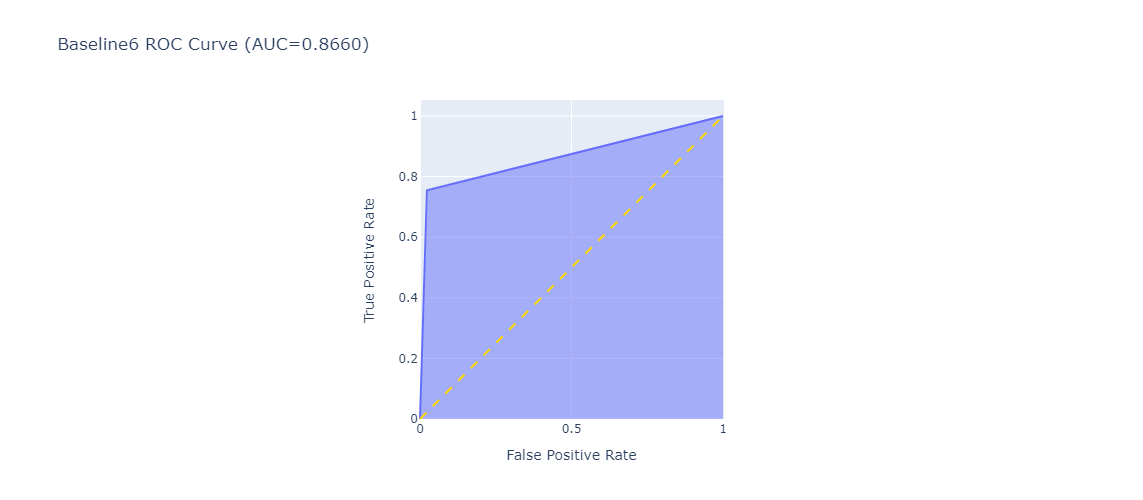

In [546]:
fpr, tpr, thresholds = roc_curve(b6_y_test, b6_test_pred)
fig = px.area(
    x=fpr, y=tpr,
    title=f'Baseline6 ROC Curve (AUC={auc(fpr, tpr):.4f})',
    labels=dict(x='False Positive Rate', y='True Positive Rate'),
    width=700, height=500
)
fig.add_shape(
    type='line', line=dict(color="gold",dash='dash'),
    x0=0, x1=1, y0=0, y1=1
)

fig.update_yaxes(scaleanchor="x", scaleratio=1)
fig.update_xaxes(constrain='domain')
fig.show()

In [547]:
print(pd.crosstab(b6_y_test, b6_test_pred, rownames=["Actual"], colnames=["Predicted"]))
print(f"\n{classification_report(b6_y_test, b6_test_pred)}")

Predicted    0    1
Actual             
0          906   21
1           65  200

              precision    recall  f1-score   support

           0       0.93      0.98      0.95       927
           1       0.90      0.75      0.82       265

    accuracy                           0.93      1192
   macro avg       0.92      0.87      0.89      1192
weighted avg       0.93      0.93      0.93      1192



### Baseline 6 Summary
The TabNet model was tested on validation data and than predicted with original validation set and then predicted test set.
* **Raw accuracy**: validation set had a score of 91.78%, test set had 92.79% which is the best of all previous baselines.
* **Auc**: validation set had a score of 0.839 , test set had 0.866 which is also the best of all previous baselines.
* **F1 score**: validation set had a score of 0.786, test set had 0.823 which is higher than the fourth baseline.

The baseline is saved for comparison as a pandas dataframe:

In [548]:
Baseline6 = pd.DataFrame({"val_acc": b6_val_score,"val_auc": b6_val_auc,"val_f1": b6_val_f1,
                          "test_acc": b6_test_score,"test_auc": b6_test_auc,"test_f1": b6_test_f1}, index=["Baseline6"])
Baseline6

,val_acc,val_auc,val_f1,test_acc,test_auc,test_f1
Baseline6,0.917785,0.838965,0.786026,0.927852,0.866032,0.823045


# Conclusion
The Baselines are improving from the 1st to the sixth, TabNet is the best for this task.
The final model had an impressive metric scores defined above, statistically meaning according to the test results:

* out of every 100 people the model will accurately identintify 93 people's loan general outcome. 
* out of every 4 individuals who defaulted their loan, the model will predict 3 correctly beforehand.  

## The Baslines:

In [549]:
Baselines = pd.concat([Baselines,Baseline6])
Baselines

,val_acc,val_auc,val_f1,test_acc,test_auc,test_f1
Baseline1,0.858221,0.769960,0.651546,0.854866,0.784073,0.667946
Baseline2,0.866611,0.788004,0.677485,0.875839,0.811032,0.713178
Baseline3,0.877517,0.811885,0.710317,0.885067,0.821007,0.731898
Baseline4,0.903523,0.805891,0.739229,0.906040,0.819670,0.758621
Baseline5,0.917785,0.847429,0.791489,0.907718,0.834223,0.771784
Baseline6,0.917785,0.838965,0.786026,0.927852,0.866032,0.823045


## Plotting Baselines for comparisons:

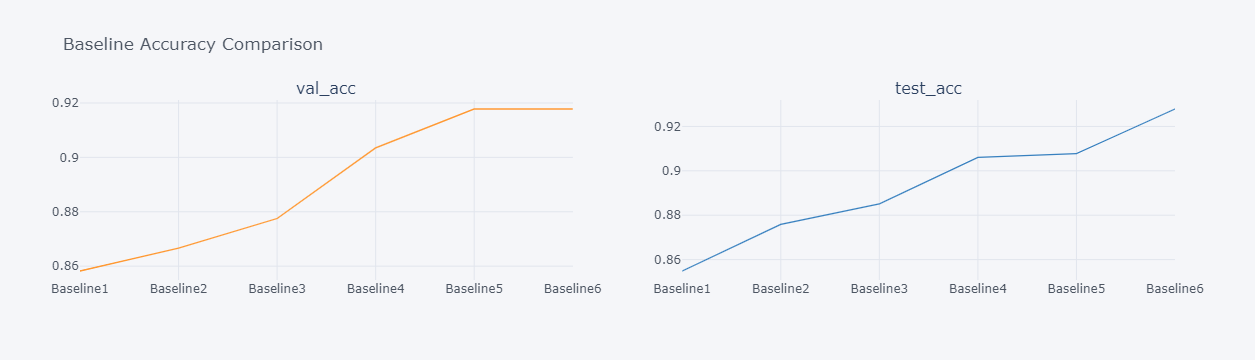

In [550]:
import plotly.graph_objs as go
ordered = ['val_acc','test_acc','val_auc','test_auc','val_f1','test_f1'] 
Baselines[ordered[:2]].iplot(subplots=True, subplot_titles=ordered[:2], legend=False, title = 'Baseline Accuracy Comparison')

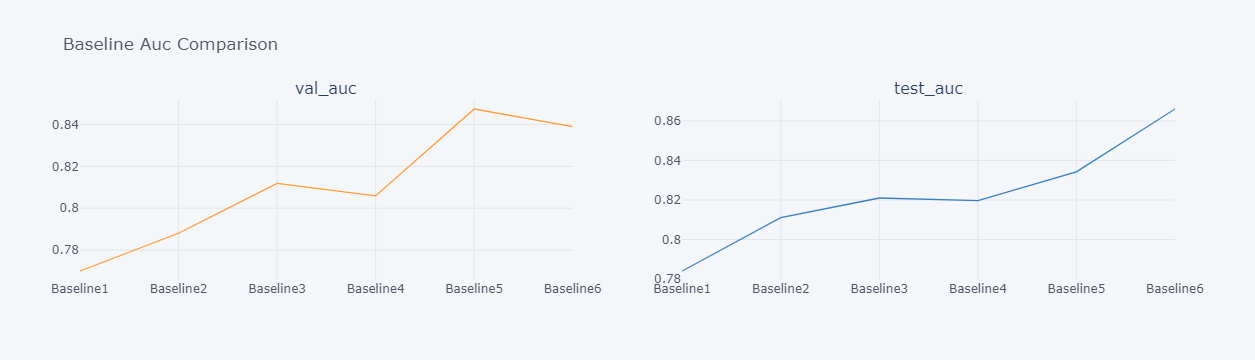

In [551]:
Baselines[ordered[2:4]].iplot(subplots=True, subplot_titles=ordered[2:4], legend=False, title = 'Baseline Auc Comparison')

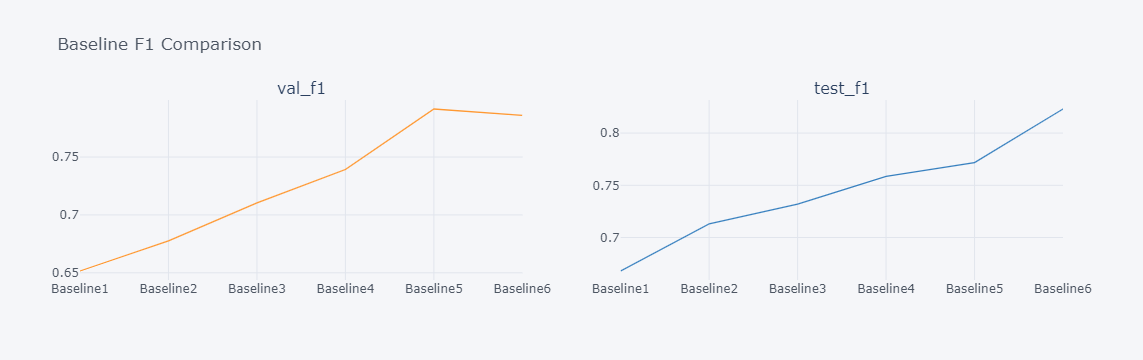

In [552]:
Baselines[ordered[4:]].iplot(subplots=True, subplot_titles=ordered[4:], legend=False, title = 'Baseline F1 Comparison')

![](https://media4.giphy.com/media/3o6ozuHcxTtVWJJn32/giphy.gif)